## Ising Model Neural Nets
Here, we develop two neural nets which are trained to classify simulation results of the Ising model into "low" and "high" temperature phases.

First we train a neural net with a single hidden layer, an then a convolutional net.

In [35]:
%matplotlib inline
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

Set the locations training, validation, and test sets.

In [5]:
train_data = '../../data/Ising/train/'
test_data = '../../data/Ising/test/'
valid_data = '../../data/Ising/valid/'

In [6]:
#highTList=os.listdir(train_data+"high")

In [7]:
#class_names = ['low', 'high']

Set up some helper functions to sort the data and labels.

The file name for each simulation is in the form ```phase_Temp_index_.npy``` where ```phase``` is either "high" or "low" and is the label we are training against. We also keep track of the temperature of each simulations, which will allow us to determine the critical phase transition temperature.

In [8]:
def one_hot_label(img):
    label,T,_,_ = img.split('_')
    if label == 'low':
        ohl = np.array([1,0])
    elif label == 'high':
        ohl = np.array([0,1])
    return ohl,T
def train_data_with_label(train_path,*args):
    train_images = []
    if args:
        for category in args:
            for i in tqdm(os.listdir(train_path + category)):
                path = os.path.join(train_path, category,i)
                img = np.load(path)
                #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                #img = cv2.resize(img, (128,128))
                train_images.append([img, one_hot_label(i)])
        shuffle(train_images)
        return train_images

def valid_data_with_label(valid_path,*args):
    valid_images = []
    if args:
        for category in args:
            for i in tqdm(os.listdir(valid_path + category)):
                path = os.path.join(valid_path, category,i)
                img = np.load(path)
                #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                #img = cv2.resize(img, (128,128))
                valid_images.append([img, one_hot_label(i)])
        shuffle(valid_images)
        return valid_images
    

Load in the train and validation sets.

Each element of the sets consists of a tuple of the form: (numpy array, one hot label, temperature)

In [9]:
train_set=train_data_with_label(train_data,'low','high')
valid_set=valid_data_with_label(valid_data,'low','high')

100%|██████████| 300/300 [00:00<00:00, 2128.43it/s]


Take a look at a few samples

(array([0, 1]), '2.4')

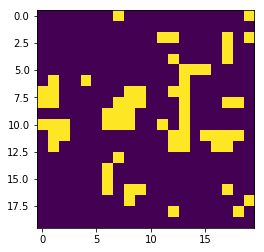

In [16]:
n_test=34
plt.imshow(train_set[n_test][0])
train_set[n_test][1]

Separate the loaded data into arrays containing the image data, label data, and temperature data.

In [17]:
tr_img_data = np.array([i[0] for i in train_set])
tr_lbl_data = np.array([i[1][0] for i in train_set])
tr_Temp_data = np.array([i[1][1] for i in train_set])
val_img_data = np.array([i[0] for i in valid_set])
val_lbl_data = np.array([i[1][0] for i in valid_set])
val_Temp_data = np.array([float(i[1][1]) for i in valid_set])

## Single hidden layer NN
Define the model for a NN with one hidden layer containing $100$ neurons.

In [28]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(20, 20)),
    keras.layers.Dense(100, activation=tf.nn.relu ),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [29]:
model1.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
model1.fit(x=tr_img_data,y=tr_lbl_data, epochs=10,batch_size=64)

Epoch 1/10
4500/4500 [==============================] - 0s 78us/step - loss: 0.2546 - acc: 0.8949
Epoch 2/10
4500/4500 [==============================] - 0s 33us/step - loss: 0.1494 - acc: 0.9458
Epoch 3/10
4500/4500 [==============================] - 0s 31us/step - loss: 0.1187 - acc: 0.9553
Epoch 4/10
4500/4500 [==============================] - 0s 34us/step - loss: 0.0897 - acc: 0.9671
Epoch 5/10
4500/4500 [==============================] - 0s 31us/step - loss: 0.0726 - acc: 0.9758
Epoch 6/10
4500/4500 [==============================] - 0s 32us/step - loss: 0.0559 - acc: 0.9829
Epoch 7/10
4500/4500 [==============================] - 0s 34us/step - loss: 0.0428 - acc: 0.9884
Epoch 8/10
4500/4500 [==============================] - 0s 32us/step - loss: 0.0322 - acc: 0.9929
Epoch 9/10
4500/4500 [==============================] - 0s 34us/step - loss: 0.0247 - acc: 0.9964
Epoch 10/10
4500/4500 [==============================] - 0s 32us/step - loss: 0.0224 - acc: 0.9971


In [31]:
val_loss, val_acc = model1.evaluate(val_img_data, val_lbl_data)
print('Test accuracy:', val_acc)

750/750 [==============================] - 0s 127us/step
Test accuracy: 0.9253333328564962


## Determine the critical temperature
First get the model predictions for the validation set, and separate the outputs for the two neurons in the final layer

In [65]:
predictions=model1.predict(val_img_data)

low_predict = predictions[:,0]
high_predict = predictions[:,1]

Now combine the temperature of the simulations with their predicted phase.

In [70]:
df1 = pd.DataFrame({'pred_low':low_predict,'pred_high':high_predict, 'Temp':val_Temp_data})
df1.head()

,pred_low,pred_high,Temp
0,0.286215,0.713785,2.6
1,0.999386,0.000614,1.7
2,0.999993,0.000007,1.9
3,0.998411,0.001589,1.6
4,0.999971,0.000029,2.2


Find the average (and standard deviation) output of each neuron for each temperature, and plot the results.

In [75]:
df2=df1.groupby('Temp').mean()
df3=df1.groupby('Temp').std()
#df.sort_values(by='Temp')

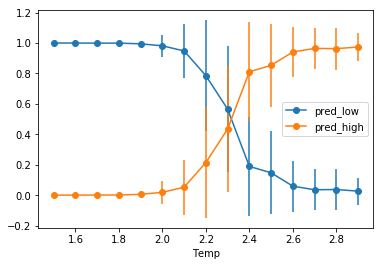

In [76]:
df2.plot(marker='o',yerr=df3)

In [66]:
#plt.plot(val_Temp_data,low_predict,'o')
#plt.plot(val_Temp_data,high_predict,'o')

In [112]:
bad_predictions=[]
for i in range(len(val_lbl_data)):
    #if (low_predict[i]>0.5 and val_lbl_data[i]=='high' and val_Temp_data[i]>=2.6):
    if (low_predict[i]>0.5 and val_Temp_data[i]>=2.6):
        bad_predictions.append(i)

In [113]:
bad_predictions

[3, 123, 205, 223, 363, 713]

[0 1] 2.6 0.8983862


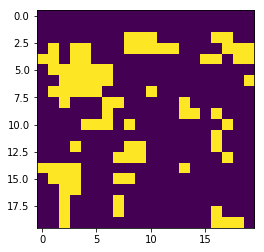

In [115]:
idx=3
plt.imshow(val_img_data[idx])
print(val_lbl_data[idx],val_Temp_data[idx],low_predict[idx])

In [77]:
#df2.plot(x='Temp',y='pred_low',marker='o')
#df2.plot(x='Temp',y='pred_high',marker='o')

In [79]:
#df2.plot(x='Temp',marker='o',yerr=df3)

## Convolutional Neural Net

In [113]:
model2 = keras.Sequential([
    #keras.layers.Flatten(input_shape=(20, 20)),
    keras.layers.Conv2D(64, (2, 2), input_shape=(20, 20, 1), padding='same'),
    keras.layers.ReLU(),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [114]:
model2.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [115]:
tr_img_data = np.array([i[0] for i in train_set]).reshape(-1,20,20,1)
val_img_data = np.array([i[0] for i in valid_set]).reshape(-1,20,20,1)

In [116]:
model2.fit(x=tr_img_data,y=tr_lbl_data, epochs=5,batch_size=64)

Epoch 1/5
4500/4500 [==============================] - 1s 172us/step - loss: 0.2058 - acc: 0.9213
Epoch 2/5
4500/4500 [==============================] - 0s 63us/step - loss: 0.1053 - acc: 0.9547
Epoch 3/5
4500/4500 [==============================] - 0s 63us/step - loss: 0.0775 - acc: 0.9673
Epoch 4/5
4500/4500 [==============================] - 0s 63us/step - loss: 0.0626 - acc: 0.9782
Epoch 5/5
4500/4500 [==============================] - 0s 64us/step - loss: 0.0458 - acc: 0.9822


In [117]:
val_loss, val_acc = model2.evaluate(val_img_data, val_lbl_data)
print('Test accuracy:', val_acc)

750/750 [==============================] - 0s 245us/step
Test accuracy: 0.9493333328564961


In [118]:
predictions2=model2.predict(val_img_data)

low_predict2 = predictions2[:,0]
high_predict2 = predictions2[:,1]

In [119]:
df4 = pd.DataFrame({'pred_low':low_predict2,'pred_high':high_predict2, 'Temp':val_Temp_data})


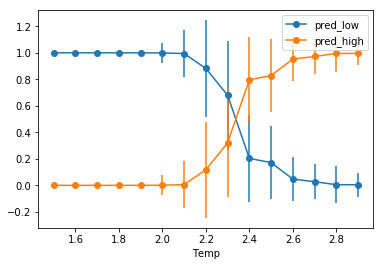

In [120]:
df5=df4.groupby('Temp').mean()
df6=df4.groupby('Temp').std()
df5.plot(marker='o',yerr=df3)